In [1]:
import pathlib
import pickle

import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn

from super_resolution.src.sen2venus_dataset import (
    create_train_validation_test_split,
    default_patch_transform,
)

from super_resolution.src.visualization import plot_gallery

In [146]:
from super_resolution.src.visualization import plot_gallery

DATA_DIR = pathlib.Path("C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

train_patches, val_patches, test_patches = create_train_validation_test_split(
    str(SITES_DIR) + "\\", sites={"FGMANAUS"}
)

In [173]:
train_loader = DataLoader(train_patches, batch_size=2)
x_train, y_train = [],[]
for i, (low_res, high_res) in enumerate(train_loader):
    x_train.append(low_res), y_train.append(high_res)

x_train, y_train = torch.cat(x_train), torch.cat(y_train)

In [338]:
f1 = 9
n1 = 64
f2 = 1
n2 = 32
f3 = 5
c = 3
input_size = 120
output_size = 256
# p3 = (output_size - 1 + f3 - input_size) // 2
p3 = 0
    
class SRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.upscale = nn.Sequential(nn.Conv2d(c, n1, f1,padding=4),
                                     nn.ReLU(),
                                     nn.Conv2d(n1,n2,f2),
                                     nn.ReLU(),
                                     nn.Conv2d(n2,c,f3,padding=2),
                                     nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False))
    def forward(self,x):
        device = x.device
        return self.upscale(x.to(device))

In [339]:
def output_size(N,F,P=0,D=1,S=1):
    return (N + 2*P - D*(F-1)-1)//S + 1

N = 128
P= 5
o1 = output_size(128,f1,P=P)
o2 = output_size(o1,f2,P=P)
o3 = output_size(o2,f3,P=P)
print(o1,o2,o3)


130 140 146


#### Checking output size of convolutions 

In [340]:
model = SRCNN()
model = model.to("cuda")
print(model)

SRCNN(
  (upscale): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Upsample(scale_factor=2.0, mode='bicubic')
  )
)


## Training

In [343]:
torch.cuda.empty_cache()
should_pin_memory = {"cuda": True, "cpu": False}

In [344]:
import torch.optim as optim
# from torch.utils.data import DataLoader
import tqdm
from torch.utils.data import DataLoader, Dataset
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

class DatasetWrapper(Dataset):
    def __init__(self, X, y=None):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        else:
            return self.X[idx], self.y[idx]

In [345]:
losses = []
epoch_losses = [] 
  
def train(model: SRCNN, x: torch.tensor, y: torch.tensor, lossfunc = nn.MSELoss(), 
          batch_size = 8, nepochs = 10, lr = 10e-4):
         
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # training loop
    dataloader = DataLoader(DatasetWrapper(x,y),
                              shuffle=True,  # Always set to true for training
                              batch_size=batch_size,  # Always try to set as powers of 2
                              drop_last=True,  # Ensures batch size is always the one given (Drops last if its is smaller)
                              pin_memory=should_pin_memory[device.type],  # Faster push to GPU 
                              )
    
    loop = tqdm(range(nepochs), ncols=110)
    for i in loop: # for each epoch
        t0 = time()
        
        epoch_loss = 0
        n_batches = 0 
        for (x_batch, y_batch) in dataloader: # for each mini-batch
            n_batches += 1
            optimizer.zero_grad()

            # Move mini-batch data to GPU
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            out = model.forward(x_batch)
            loss = lossfunc(out,y_batch)
            epoch_loss += loss.item()
            losses.append(loss.item())

            # gradient descent 
            loss.backward()
            optimizer.step()
        
        epoch_losses.append(epoch_loss)  
        epoch_loss /= n_batches
        loop.set_postfix(loss="%5.5f" % (epoch_loss)) 
    




### Testing dataloader 

In [346]:
dataloader = DataLoader(DatasetWrapper(x_train, y_train),
                              shuffle=True,  # Always set to true for training
                              batch_size=8,  # Always try to set as powers of 2
                              drop_last=True,  # Ensures batch size is always the one given (Drops last if its is smaller)
                              pin_memory=should_pin_memory[device.type]  # Load data in parallel but costs more memory
                              )

for (x_batch, y_batch) in dataloader: # for each mini-batch
    print(x_batch.shape)

torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])


In [391]:
model = SRCNN()
train(model, x_train, y_train, nepochs=1000,batch_size = 4)

100%|███████████████████████████████████████████████████████| 1000/1000 [01:31<00:00, 10.89it/s, loss=0.00469]


In [401]:
out = model.forward(x_train.to("cuda"))

c:\Users\skouf\Documents\2024\STAT3007\stat3007-project\myenv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


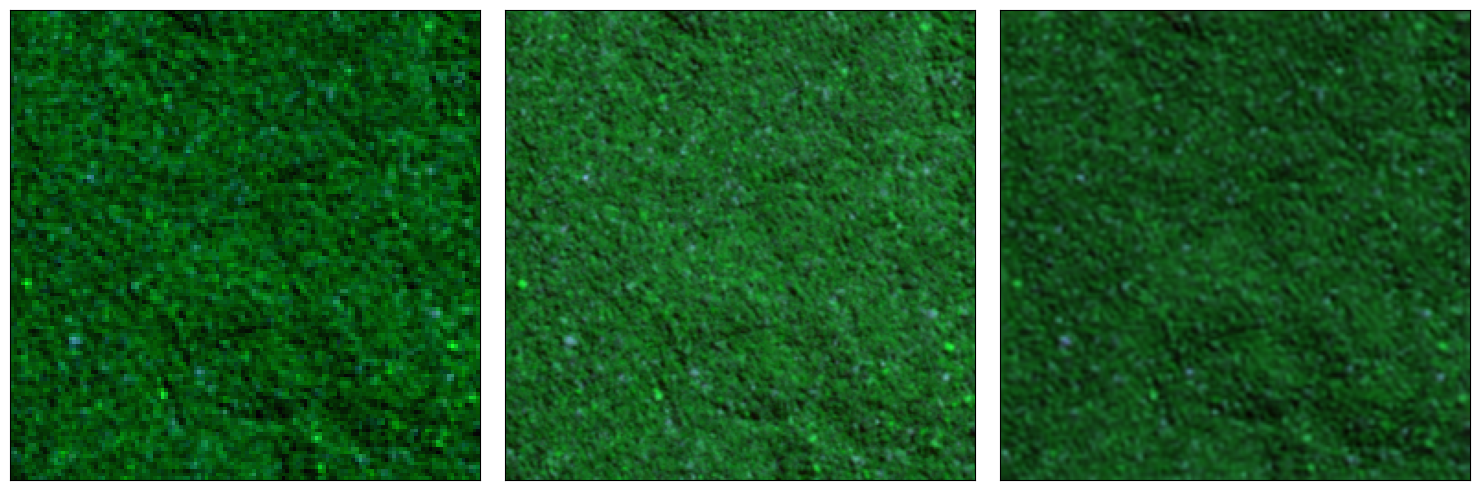

In [402]:
plot_gallery(
    [
        x_train[0].permute(1, 2, 0).cpu().numpy(),
        y_train[0].permute(1, 2, 0).cpu().numpy(),
        out[0].permute(1, 2, 0).cpu().detach().numpy(),
    ],
    xscale=5,
    yscale=5,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


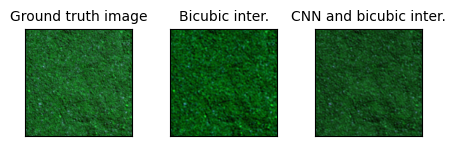

In [415]:
o = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)(x_train)
o.shape


plot_gallery(
   [y_train[0].permute(1,2,0), o[0].permute(1, 2, 0), out[0].permute(1, 2, 0).cpu().detach().numpy()],
   titles = ["Ground truth image", "Bicubic inter.", "CNN and bicubic inter."]
)


In [413]:
print(nn.MSELoss()(y_train,o))
print(nn.MSELoss()(y_train,out.to("cpu")))

tensor(0.0122)
tensor(0.0052, grad_fn=<MseLossBackward0>)
